In [1]:
import pandas as pd
import numpy as np
import copy
import sklearn
from matplotlib import pyplot as plt
import hydroeval as he

In [2]:
from utils import conceptual_s_curve

In [3]:
# %%%%%%%%%%%%%%%
# We choose one reservoir for demonstration
select_id = '55' # GRanD ID of the selected reservoir

# providing the historical storage series
df = pd.read_csv('D:\\download\\ResOps_data\\data_water_year\\'+select_id+'.csv') 
df = df[['Time', 'storage']]
df['Time'] = pd.to_datetime(df["Time"])
df = df[df['Time']>='1990-01-01']
df['DOY'] = df["Time"].dt.dayofyear
df['month'] = df["Time"].dt.month
df = df.reset_index(drop=True)


In [4]:
# %%%%%%%%%%%%%%%
# generating the daily median storage for each day-of-year (DOY)

df_adjusted = df.copy() # avoiding errors related to leap year
df_adjusted['Time'] = pd.to_datetime(df_adjusted["Time"])
df_adjusted["is_leap_year"] = df_adjusted.Time.dt.is_leap_year
df_adjusted["DOY_adjusted"] = df_adjusted.apply(
lambda row: row.DOY - 1 
if (row.is_leap_year and row.DOY >= 60) 
else row.DOY, 
axis=1)

daily_median_s = df_adjusted.groupby(['DOY_adjusted'])['storage'].median().values
print(len(daily_median_s))

365


In [5]:
# %%%%%%%%%%%%%%%
# Function 'derive_curve_parameters()': to derive the six parameters of conceptual storage regulation curve 
# based on the series of daily median storage for each day-of-year (series length=365)
Sty_month1, Sty_month2, Sty_month3, Sty_month4, Sty_a1, Sty_a2 = conceptual_s_curve.derive_curve_parameters(daily_median_s)


A1：6
A2：9
A3：9
A4：6
S_A4-A1：177.0952
S_A2-A3：39.0366


In [6]:
# %%%%%%%%%%%%%%%
# Function 'doy_typical_storage()' can provide typical storage for each DOY from the pre-derived curve parameters
df_Sty = conceptual_s_curve.doy_typical_storage(Sty_month1, Sty_month2, Sty_month3, Sty_month4, Sty_a1, Sty_a2)

Text(0, 0.5, 'storage (million $m^3$)')

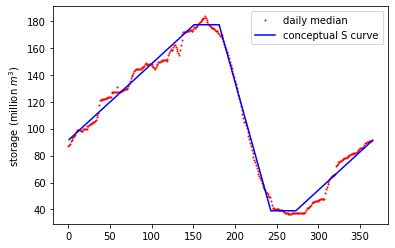

In [7]:
plt.plot(daily_median_s, color='r', marker='o', markersize=1, linestyle='', label='daily median')
plt.plot(df_Sty['DOY'], df_Sty['typical_S'], color='b', linestyle='-', label='conceptual S curve')
plt.legend()
plt.ylabel("storage (million $m^3$)")

In [8]:
# %%%%%%%%%%%%%%%
# Function 'derive_curve_parameters()' can also take the series of 
#              monthly characteristic storage levels (series length=12) as input
 
# here, the historical observed monthly median storage series is generated for demonstration;
# users may provide the monthly median storage series based on remote sensing data 
monthly_median_s = df.groupby(['month']).median()['storage'].values
print(len(monthly_median_s))

Sty_month1m, Sty_month2m, Sty_month3m, Sty_month4m, Sty_a1m, Sty_a2m = conceptual_s_curve.derive_curve_parameters(monthly_median_s)


12
A1：6
A2：9
A3：9
A4：6
S_A4-A1：174.3209
S_A2-A3：40.0427


In [9]:
# %%%%%%%%%%%%%%%
df_Stym = conceptual_s_curve.doy_typical_storage(Sty_month1m, Sty_month2m, Sty_month3m, Sty_month4m, Sty_a1m, Sty_a2m)

Text(0, 0.5, 'storage (million $m^3$)')

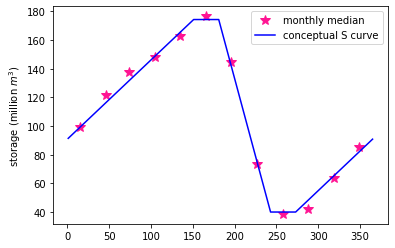

In [10]:
month_days = np.array([31,28,31,30,31,30,31,31,30,31,30,31]) # Days per month for non-leap year
month_mid_doy = np.cumsum(month_days) - month_days + 15 # assuming the monthly values represents the  for the 15th day of each month

plt.plot(month_mid_doy, monthly_median_s, color='deeppink', marker='*', linestyle='', markersize=10, label='monthly median')
plt.plot(df_Stym['DOY'], df_Stym['typical_S'], color='b', linestyle='-', label='conceptual S curve')
plt.legend()
plt.ylabel("storage (million $m^3$)")